In [7]:
%matplotlib inline 
# helps python talk to matplotlib, necessary before any plotting

import sys # provides information about constants, functions and methods
import datacube 
import numpy as np
import xarray as xr
import pandas as pandas
import matplotlib.pyplot as plt
from scipy import stats
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS
from odc.ui import with_ui_cbk

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_plotting import display_map
from dea_plotting import rgb

In [3]:
dc = datacube.Datacube(app='Change_detection')

In [4]:
# Define an area of interest
latitude = (-35.271, -35.331)
longitude = (149.256, 149.356)

# Set the range of dates for the complete sample
time = ('2015-01-01','2019-09-01')

# Set the date to seperate the data into two samples for computation
time_baseline = '2017-12-01'

In [5]:
display_map(x=longitude,y=latitude)

In [10]:
# Choose products to load
# Here, the Sentinel-2A and Sentinel-2B products are chosen
products = ['s2a_ard_granule', 's2b_ard_granule']

# Specify the parameters to pass to the load query
query = {
    "x": longitude,
    "y": latitude,
    "time": time,
    "measurements": [
        "nbart_red",  # Red band
        "nbart_green",  # Green band
        "nbart_blue",  # Blue band
        "nbart_nir_1",  # Near-infrared band
#         "fmask"  # Cloud masking band
    ],
    "output_crs": "EPSG:3577",
    "resolution": (-10, 10)
}

# Load the data
ds_s2 = load_ard(dc, products=products, min_gooddata=0.7, **query)

Loading s2a_ard_granule data
    Filtering to 62 out of 130 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 38 out of 76 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 100 observations 


In [11]:
print(ds_s2)

<xarray.Dataset>
Dimensions:      (time: 100, x: 990, y: 784)
Coordinates:
  * y            (y) float64 -3.958e+06 -3.958e+06 ... -3.966e+06 -3.966e+06
  * x            (x) float64 1.561e+06 1.561e+06 ... 1.571e+06 1.571e+06
  * time         (time) datetime64[ns] 2015-09-13T00:06:33.742500 ... 2019-08-28T00:02:49.024000
Data variables:
    nbart_red    (time, y, x) float32 643.0 503.0 496.0 ... 724.0 678.0 737.0
    nbart_green  (time, y, x) float32 543.0 494.0 459.0 ... 641.0 518.0 605.0
    nbart_blue   (time, y, x) float32 423.0 359.0 349.0 ... 409.0 378.0 439.0
    nbart_nir_1  (time, y, x) float32 1877.0 1437.0 1447.0 ... 2152.0 2314.0
Attributes:
    crs:      EPSG:3577


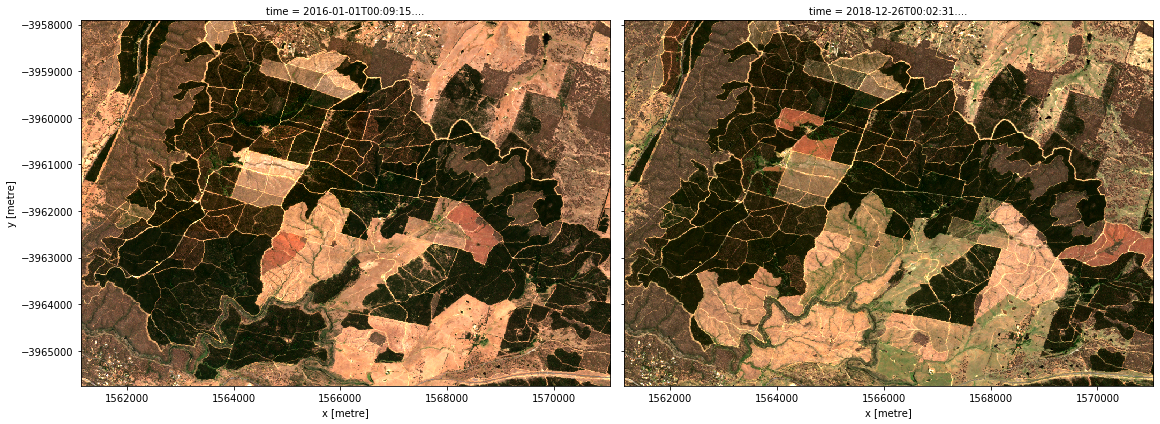

In [12]:
# Set the timestep to visualise
initial_timestep = 1
final_timestep = 76

# Generate RGB plots at each timestep
rgb(ds_s2, index=[initial_timestep,final_timestep])

In [15]:
# Calculate NDVI and add it to the loaded dataset
ds_s2 = calculate_indices(ds_s2,"NDVI",collection="ga_s2_1")

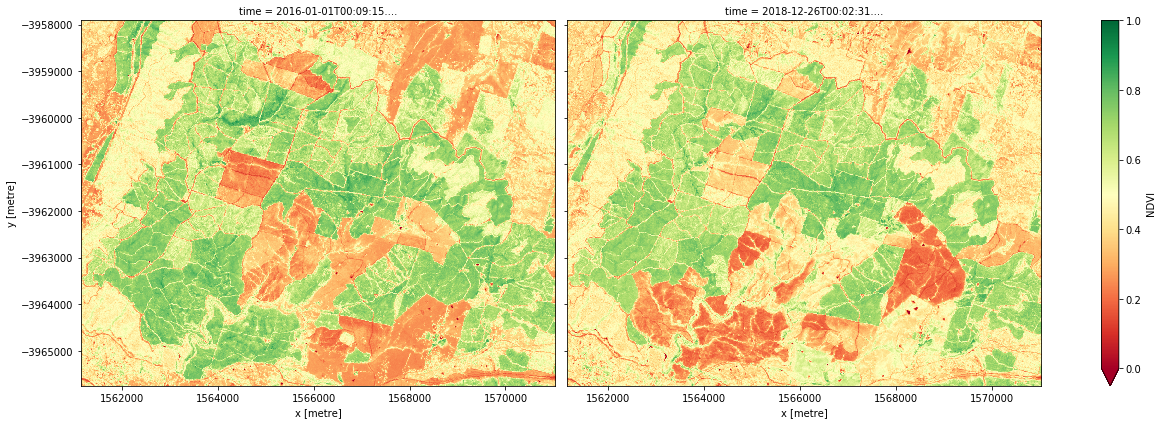

In [19]:
# Plot the NDVI values for pixels classified as water for the two dates.
ds_s2.NDVI.isel(time=[initial_timestep,final_timestep]).plot.imshow('x','y',col='time',vmin=0,vmax=1,figsize=(18,6),cmap='RdYlGn')
plt.show()

In [20]:
# Make samples
baseline_sample = ds_s2.NDVI.sel(time=ds_s2['time']<=np.datetime64(time_baseline))
print(f"Number of observations in baseline sample: {len(baseline_sample.time)}")

postbaseline_sample = ds_s2.NDVI.sel(time=ds_s2['time']>np.datetime64(time_baseline))
print(f"Number of observations in postbaseline sample: {len(postbaseline_sample.time)}")

# Record coordinates for reconstructing xarray objects
sample_lat_coords = ds_s2.coords['y']
sample_lon_coords = ds_s2.coords['x']

Number of observations in baseline sample: 41
Number of observations in postbaseline sample: 59


In [21]:
# Perform the t-test on the postbaseline and baseline samples
tstat, p_tstat = stats.ttest_ind(postbaseline_sample.values,
                                baseline_sample.values,
                                equal_var=False,
                                nan_policy='omit',
)

# Convert results to an xarray for further analysis
t_test = xr.Dataset(
{
    't_stat':(['y','x'],tstat),
    'p_val':(['y','x'], p_tstat)
},
coords={
    'x':(['x'],sample_lon_coords.values),
    'y':(['y'],sample_lat_coords.values)
},
attrs={
    'crs':'EPSG:3577',
})
print(t_test)

<xarray.Dataset>
Dimensions:  (x: 990, y: 784)
Coordinates:
  * x        (x) float64 1.561e+06 1.561e+06 1.561e+06 ... 1.571e+06 1.571e+06
  * y        (y) float64 -3.958e+06 -3.958e+06 ... -3.966e+06 -3.966e+06
Data variables:
    t_stat   (y, x) float64 -0.6015 -0.4542 -0.8988 -0.8422 ... 6.25 6.441 6.157
    p_val    (y, x) float64 0.5498 0.6513 0.3725 ... 1.456e-08 6.664e-08
Attributes:
    crs:      EPSG:3577


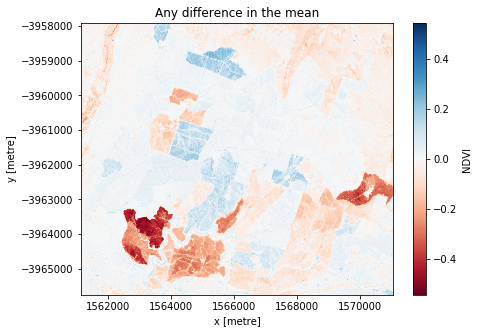

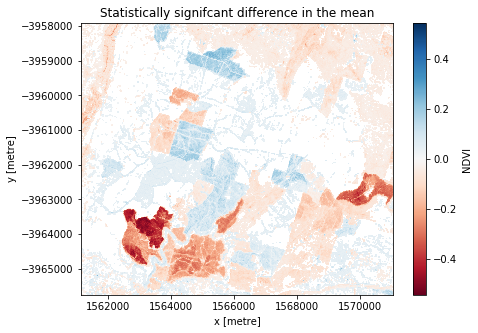

In [24]:
# Set the sig level
sig_level = 0.05

# Plot any difference in the mean
diff_mean = postbaseline_sample.mean(dim=['time'])-baseline_sample.mean(dim=['time'])

fig, ax = plt.subplots(1,1,figsize=(7,5))
diff_mean.plot(cmap='RdBu')
ax.set_title('Any difference in the mean')
plt.show()

# Plot any difference in the mean classified as significant
sig_diff_mean = postbaseline_sample.mean(dim=['time']).where(t_test.p_val<0.05)- baseline_sample.mean(dim=['time']).where(t_test.p_val < sig_level)

fig, ax = plt.subplots(1,1,figsize=(7,5))
sig_diff_mean.plot(cmap='RdBu')
ax.set_title('Statistically signifcant difference in the mean')
plt.show()

In [25]:
# Make datasets into xarrays for output
diff_mean_out = xr.Dataset({'diff_mean':diff_mean},attrs={'crs':CRS('EPSG:3577')})
sig_diff_mean_out = xr.Dataset({'sig_diff_mean':sig_diff_mean},attrs={'crs':CRS('EPSG:3577')})

# Write output to geotiffs
write_geotiff(filename='ttset_diff_mean.tif',dataset=diff_mean_out)
write_geotiff(filename='ttest_sig_diff_mean.tif',dataset=sig_diff_mean_out)